## Inpost forecasting
Author: Andrii Zapukhlyi

#### Data description: 
- DimDates - CSV file - Database with date information (Year, Month, Day, Weekday, Weekend, Holiday, etc.)
- PostingVolume - Parquet file - Database with daily transmissions (From January 1, 2021 to August 31, 2023). The data is grouped per day by two services APM and COURIER along with a separated customer X. This customer provides us with its order forecast every month at the end of the previous month
- Customers_Orders - EXCEL file - Data provided by customer (X) since the beginning of 2023. The data for the upcoming month is sent at the end of the previous month. The file contains the number of orders expected by the customer each day
- Task_Data_Temperature - Folder with CSV Files - The folder contains CSV files, where each file (for each month - between January 2021 and August 2023) stores data on temperatures (maximum, average, minimum temperature) and precipitation (rain and snow). The data is collected for two cities: Warszaw and Krakow


#### Project objective:
Import, preprocess, analyze the provided datasets and develop predictive models to forecast the number of transmissions for a specific day in the upcoming week or month

## Data and libraries import

In [249]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
from sklearn.model_selection import cross_val_score


In [250]:
df1 = pd.read_csv("dimDates_Task.csv", sep = ";")
df2 = pd.read_parquet("Posting_Volumes")
df3 = pd.read_excel("X_ClientORDERS.xlsx")
df4 = pd.DataFrame()

I'll use `os` library to merge all CSV files in the folder `Zadanie_Dane_Temperatura` with temperature data into one DataFrame

In [251]:
temp_list = []

for file in os.listdir("Zadanie_Dane_Temperatura"):
    if file.endswith(".csv"):
        temp_df = pd.read_csv(f"Zadanie_Dane_Temperatura/{file}")
        temp_list.append(temp_df)

df4 = pd.concat(temp_list, ignore_index=True)

In [252]:
df1.head()

,datePk,dateId,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,...,courierBillingPeriodStartDateFk,courierBillingPeriodEndDateFk,xlsDate,dwhDateFrom,dwhDateTo,dwhCurrRec,dwhAuditCd,dwhAuditCp,dwhAuditMd,dwhAuditMp
0,20201004,2020-10-04,2020,2020,10.202,T40-2020,Q4-2020,10,4,th,...,20201001,20201015,44108,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1,20200810,2020-08-10,2020,2020,8.202,T33-2020,Q3-2020,8,10,th,...,20200801,20200815,44053,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
2,20200930,2020-09-30,2020,2020,9.202,T40-2020,Q3-2020,9,30,th,...,20200916,20200930,44104,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
3,20200521,2020-05-21,2020,2020,5.202,T21-2020,Q2-2020,5,21,st,...,20200516,20200531,43972,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
4,20200527,2020-05-27,2020,2020,5.202,T22-2020,Q2-2020,5,27,th,...,20200516,20200531,43978,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719


In [253]:
df2.head()

,postingDateFk,Product,Customer,Volume
0,20210101,APM,X,2401.301452
1,20210102,APM,X,20195.515269
2,20210103,APM,X,63561.702640
3,20210104,APM,X,40310.645622
4,20210105,APM,X,54800.879137


In [254]:
df3.head()

,DateId,Orders
0,20230101,161366.064671
1,20230102,296627.324653
2,20230103,378262.368584
3,20230104,320907.583398
4,20230105,93098.214405


In [255]:
df4.head()

,Nazwa stacji,Rok,Miesiac,Dzien,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
0,KRAKOW,2021,8,1,23.9,17.3,20.1,5.7,0
1,KRAKOW,2021,8,2,22.8,14.4,17.2,0.5,0
2,KRAKOW,2021,8,3,25.6,11.6,18.3,0.4,0
3,KRAKOW,2021,8,4,24.9,14.3,19.4,5.2,0
4,KRAKOW,2021,8,5,21.5,15.9,17.5,103.4,0


There are 4 datasets with different data, which will be useful for prediction, so I'll join them into one

## Data wrangling

In [256]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DateId  243 non-null    int64  
 1   Orders  242 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.9 KB


The dataset containing client orders includes a `DateId` column in `int64` format. To convert this column into a datetime format, it is necessary first to convert it to a string representation before performing the datetime conversion

In [257]:
df3["DateId"] = df3["DateId"].astype(str)

The temperature dataset contains separate columns for year, month, and day. I have combined these columns into a single string column formatted as "Year-month-day" to match the date format used in the other datasets

In [258]:
temp_date = []

for i in range(len(df4)):
    rok = df4["Rok"].values[i]
    miesiac = df4["Miesiac"].values[i]
    dzien = df4["Dzien"].values[i]
    temp_date.append(f"{rok}-{miesiac}-{dzien}")
    
df4["date"] = temp_date

In [259]:
df1["date"] = pd.to_datetime(df1["dateId"])
df2["date"] = pd.to_datetime(df2["postingDateFk"])
df3["date"] = pd.to_datetime(df3["DateId"], format="%Y%m%d")
df4["date"] = pd.to_datetime(df4["date"])
df1.drop(["dateId"], axis=1, inplace=True)
df2.drop(["postingDateFk"], axis = 1, inplace = True)
df3.drop(["DateId"], axis= 1, inplace = True)
df4.drop(["Rok", "Miesiac", "Dzien"], axis=1, inplace = True)

Then, I created a `date` feature in each dataset with datetime format and dropped old columns with date

In [260]:
df1.date, df2.date, df3.date, df4.date

(0      2020-10-04
 1      2020-08-10
 2      2020-09-30
 3      2020-05-21
 4      2020-05-27
           ...    
 1456   2020-03-05
 1457   2020-04-17
 1458   2020-11-04
 1459   2020-11-16
 1460   2021-01-17
 Name: date, Length: 1461, dtype: datetime64[ns],
 0      2021-01-01
 1      2021-01-02
 2      2021-01-03
 3      2021-01-04
 4      2021-01-05
           ...    
 3887   2023-08-27
 3888   2023-08-28
 3889   2023-08-29
 3890   2023-08-30
 3891   2023-08-31
 Name: date, Length: 3892, dtype: datetime64[ns],
 0     2023-01-01
 1     2023-01-02
 2     2023-01-03
 3     2023-01-04
 4     2023-01-05
          ...    
 238   2023-08-27
 239   2023-08-28
 240   2023-08-29
 241   2023-08-30
 242   2023-08-31
 Name: date, Length: 243, dtype: datetime64[ns],
 0      2021-08-01
 1      2021-08-02
 2      2021-08-03
 3      2021-08-04
 4      2021-08-05
           ...    
 1941   2022-11-26
 1942   2022-11-27
 1943   2022-11-28
 1944   2022-11-29
 1945   2022-11-30
 Name: date, Length: 1946,

In [261]:
print("Shapes of the data frames:")
print("df1:", df1.shape,
      "\ndf2:", df2.shape,
      "\ndf3:", df3.shape,
      "\ndf4:", df4.shape)

Shapes of the data frames:
df1: (1461, 53) 
df2: (3892, 4) 
df3: (243, 2) 
df4: (1946, 7)


In [262]:
df = df2.merge(df1, left_on="date", right_on = "date", how="left")
df = df.merge(df3, left_on="date", right_on = "date", how="left")
df = df.merge(df4, left_on="date", right_on = "date", how="left")
df.to_csv("data.csv", index=False)
df.sample(5)

,Product,Customer,Volume,date,datePk,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,...,dwhAuditCp,dwhAuditMd,dwhAuditMp,Orders,Nazwa stacji,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
3684,APM,Rest,153411.131243,2023-05-20,20230520,2023,2023,5.2023,T20-2023,Q2-2023,...,1904719,2020-07-03 13:51:15.673,1904719,266492.523761,KRAKOW,22.6,10.4,16.3,0.0,0
810,APM,X,217475.609791,2022-02-10,20220210,2022,2022,2.2022,T6-2022,Q1-2022,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,KRAKOW,11.8,5.0,7.3,0.2,0
6804,COURIER,Rest,226439.922912,2022-04-29,20220429,2022,2022,4.2022,T17-2022,Q2-2022,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,KRAKOW,17.9,5.1,11.1,0.0,0
3040,APM,Rest,126685.812729,2022-07-02,20220702,2022,2022,7.2022,T26-2022,Q3-2022,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,KRAKOW,32.1,16.6,21.7,0.2,0
1128,APM,X,157777.942394,2022-07-19,20220719,2022,2022,7.2022,T29-2022,Q3-2022,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,KRAKOW,30.4,13.9,22.3,0.0,0


I combined the datasets using the `merge()` function from pandas, which operates similarly to `SQL JOIN`. <br>
The second DataFrame, which contains the daily postings and includes the target variable, served as the base for merging additional datasets using a left join.

In [263]:
print(f"Shape: {df.shape}, NaN in the dataset: {df.isna().sum().sum()}, NaN in Orders: {df.Orders.isna().sum()}")

Shape: (7784, 63), NaN in the dataset: 5848, NaN in Orders: 5848


There are **5,848 NaN** values, all located in the `Orders` column since data for this column has been collected only after January 2023. <br>
I can't remove these rows as they constitute the majority of the DataFrame, so I will impute these missing values instead.

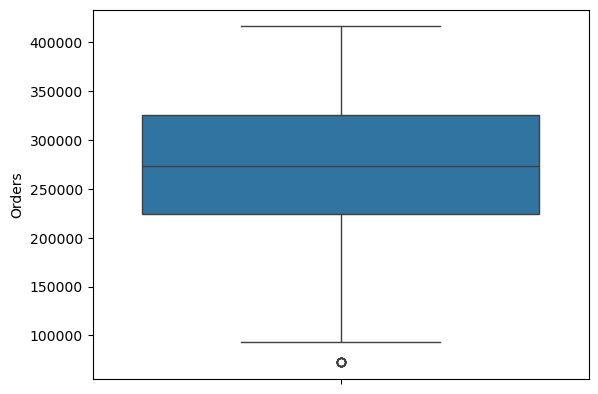

In [264]:
sns.boxplot(df.Orders.dropna())
plt.show()

There are **outliers** in the `Orders` variable

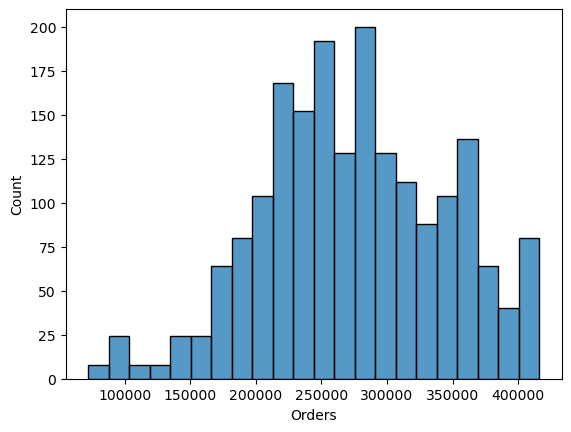

In [265]:
sns.histplot(df.Orders.dropna())
plt.show()

The distribution of the variable is not closely similar to the **Normal distribution**

In [266]:
print(np.mean(df.Orders.dropna()), np.median(df.Orders.dropna()))

275094.3768266949 273695.994968893


The mean and median values differ by approximately 2000 points. I prefer using the **median** to impute the NaN values.

In [267]:
df["Orders"] = df["Orders"].fillna(np.median(df.Orders.dropna()))

In [268]:
df.isna().sum().sum()

0

In [269]:
num = list(df.describe().columns)
num.remove("date")
categ = [col for col in df.columns if col not in num]

Besides, I created the lists of numerical and category features to make the following analysis easier.

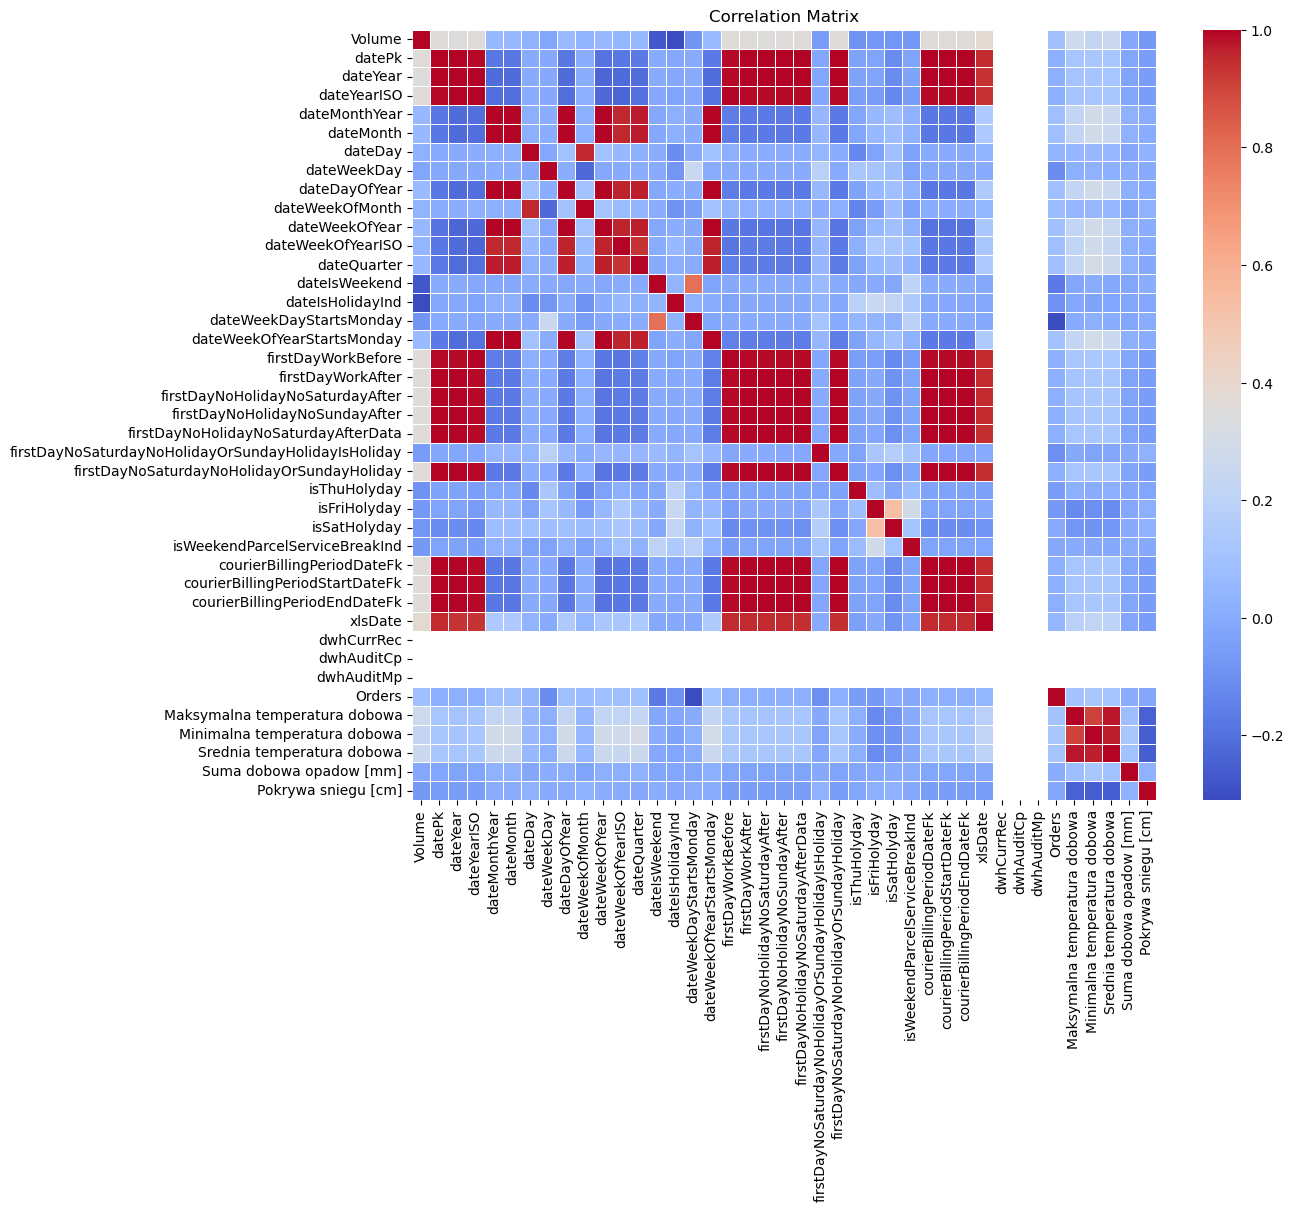

In [270]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[num].corr(), cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [271]:
df["dwhCurrRec"].unique(), df["dwhAuditCp"].unique(), df["dwhAuditMp"].unique()

(array([1]), array([1904719]), array([1904719]))

Most features have a **weak linear correlation** or no linear correlation at all with the target value. <br>
The columns `dwhCurrRec`, `dwhAuditCp`, and `dwhAuditMp` have empty values on the chart, because each of them has only one unique value.

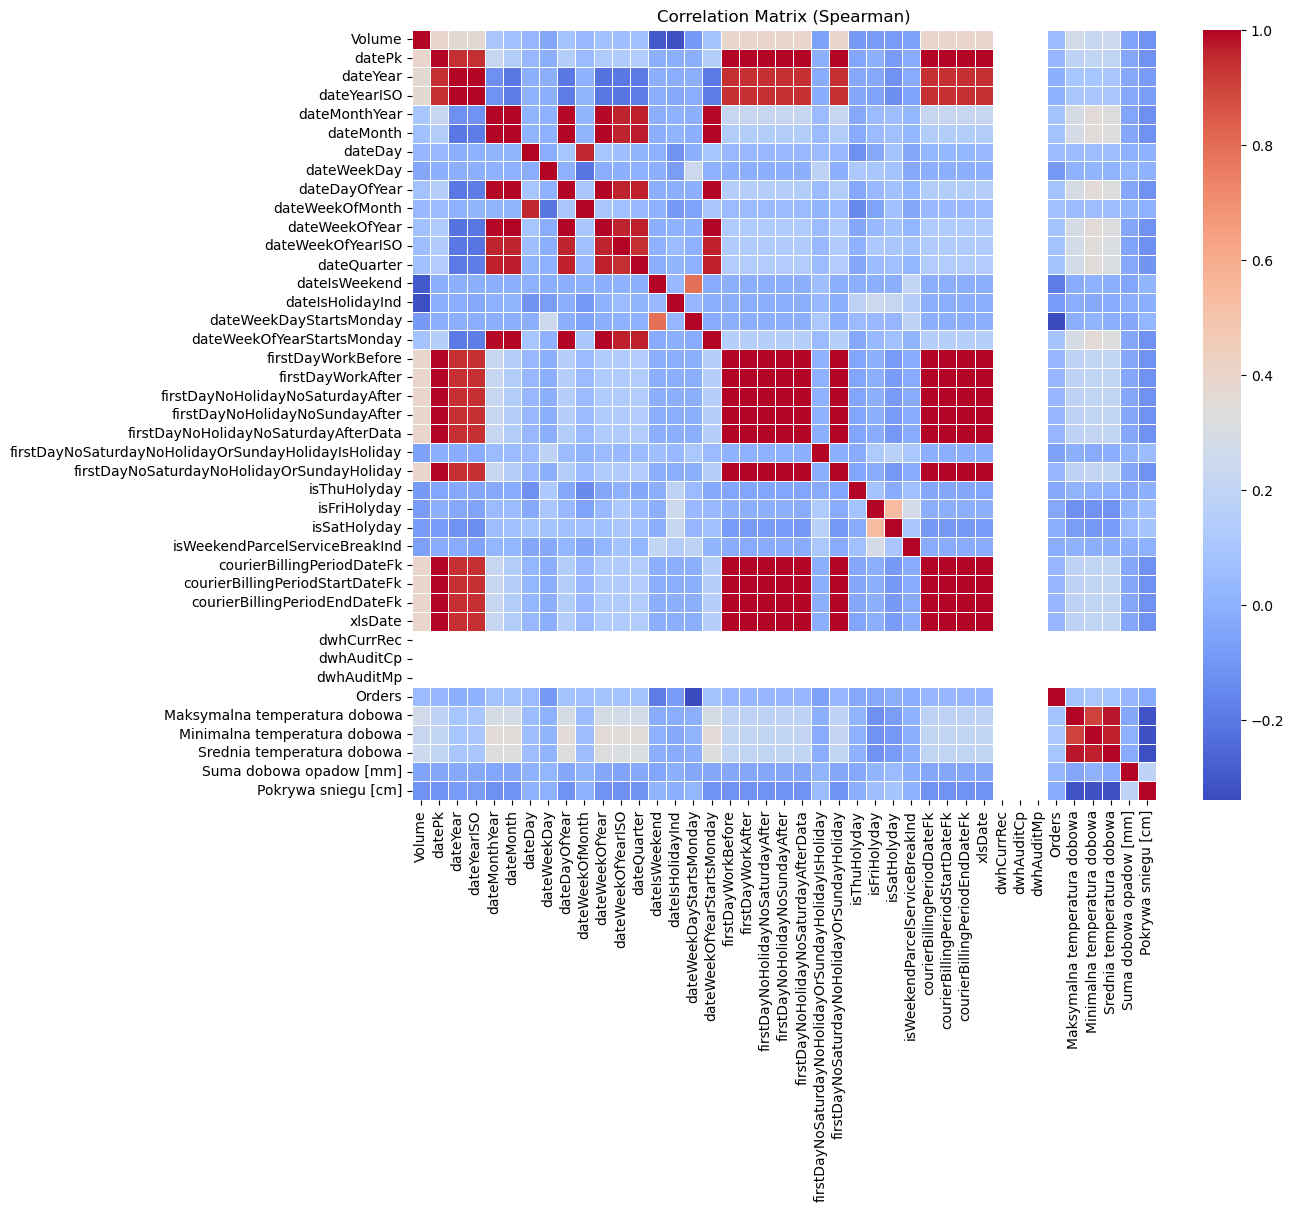

In [272]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[num].corr(method="spearman"), cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Spearman)')
plt.show()

Spearman's rank correlation coefficient indicates **stronger** relationships between the target value and the predictors.

In [273]:
print("The features most strongly linearly correlated with the target:")
np.abs(df[num].corr()["Volume"]).sort_values(ascending=False).head(5)

The features most strongly linearly correlated with the target:


Volume                             1.000000
xlsDate                            0.378266
firstDayWorkBefore                 0.360402
courierBillingPeriodEndDateFk      0.355807
courierBillingPeriodStartDateFk    0.355804
Name: Volume, dtype: float64

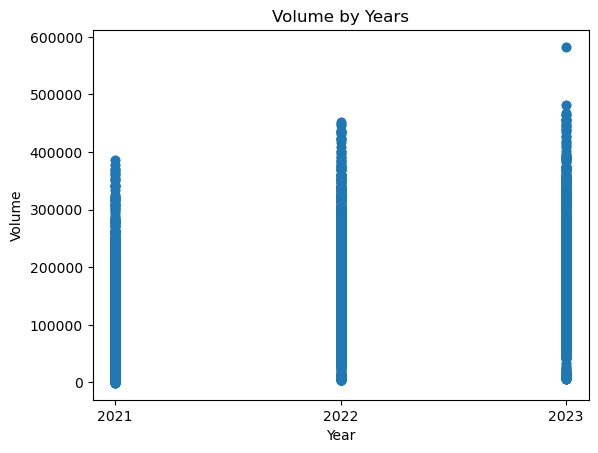

In [274]:
plt.scatter(df["dateYear"], df["Volume"])
plt.xticks(ticks=df['dateYear'].unique())
plt.xlabel("Year")
plt.ylabel("Volume")
plt.title("Volume by Years")
plt.show()

The above chart shows that `Volume` is increasing each Year

## Data preprocessing

In [275]:
df.describe()

,Volume,date,datePk,dateYear,dateYearISO,dateMonthYear,dateMonth,dateDay,dateWeekDay,dateDayOfYear,...,xlsDate,dwhCurrRec,dwhAuditCp,dwhAuditMp,Orders,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
count,7784.000000,7784,7.784000e+03,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,...,7784.000000,7784.0,7784.0,7784.0,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000
mean,143536.470533,2022-05-02 00:00:00.000000256,2.021936e+07,2021.874615,2021.868448,6.228909,6.026721,15.716341,4.000000,167.765673,...,44683.000000,1.0,1904719.0,1904719.0,274043.793951,14.826310,6.286948,10.062384,1.078263,0.345838
min,-876.759667,2021-01-01 00:00:00,2.021010e+07,2021.000000,2020.000000,1.202100,1.000000,1.000000,1.000000,1.000000,...,44197.000000,1.0,1904719.0,1904719.0,72473.494555,-12.800000,-17.500000,-15.700000,0.000000,0.000000
25%,80150.606161,2021-09-01 00:00:00,2.021090e+07,2021.000000,2021.000000,3.202300,3.000000,8.000000,2.000000,82.000000,...,44440.000000,1.0,1904719.0,1904719.0,273695.994969,6.700000,0.400000,3.100000,0.000000,0.000000
50%,130202.764469,2022-05-02 00:00:00,2.022050e+07,2022.000000,2022.000000,6.202200,6.000000,16.000000,4.000000,163.000000,...,44683.000000,1.0,1904719.0,1904719.0,273695.994969,15.400000,6.100000,10.000000,0.000000,0.000000
75%,193735.702340,2022-12-31 00:00:00,2.022123e+07,2022.000000,2022.000000,9.202100,9.000000,23.000000,6.000000,244.000000,...,44926.000000,1.0,1904719.0,1904719.0,273695.994969,22.800000,12.500000,17.200000,0.000000,0.000000
max,582617.649973,2023-08-31 00:00:00,2.023083e+07,2023.000000,2023.000000,12.202200,12.000000,31.000000,7.000000,365.000000,...,45169.000000,1.0,1904719.0,1904719.0,416068.107760,36.700000,21.900000,28.200000,103.400000,27.000000
std,87918.250569,NaN,7.740076e+03,0.780531,0.786080,3.314388,3.314405,8.795459,2.000128,101.275771,...,280.898802,0.0,0.0,0.0,34873.999597,9.659122,7.419088,8.284276,4.160206,2.033543


In [276]:
scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])

I scaled the dataset with StandardScaler (Z-score normalization) because the variables have different ranges.

In [277]:
encoded_data = pd.get_dummies(df[categ], columns=categ)
df = pd.concat([df[num], encoded_data], axis=1)

Also, I encoded category variables to build predictive models

I will remove `[`, `]` and `<` symbols from the column names for the XGBoost regression

In [278]:
df.columns = df.columns.str.replace('[', '', regex=False) \
                       .str.replace(']', '', regex=False) \
                       .str.replace('<', '', regex=False)

In [279]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Volume"], axis=1), df.Volume, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

(6227, 1262) (1557, 1262)


After splitting the dataset into training and test sets with 20% allocated to the test set, the training set consists of 6,227 observations while the test set contains 1,557 observations. <br> 
It's important to note that the number of columns increased from 63 to 1,262 due to the encoding of categorical variables to prevent model overfitting.

## Modeling

I will develop and evaluate 4 machine learning regression models — **Linear Regression**, **Support Vector Regression**, **Random Forest Regression**, and **XGBoost Regression** — to forecast the target variable and compare their performance to determine the best-performing model based on evaluation metrics.

In [280]:
tic = time.time()
mod_lr = LinearRegression()
mod_lr.fit(X_train,y_train)
pred_lr = mod_lr.predict(X_test)
toc = time.time()

print("Linear Regression:")
print(f"R^2: {r2_score(y_test, pred_lr)}, MSE: {mean_squared_error(y_test, pred_lr)}, MAE: {mean_absolute_error(y_test, pred_lr)}")
print("Modeling time:", np.round(toc-tic,2), "s")

Linear Regression:
R^2: 0.8818019341695486, MSE: 0.11415755733255513, MAE: 0.26816531246043424
Modeling time: 1.07 s


In [281]:
tic = time.time()
mod_svr = SVR()
mod_svr.fit(X_train,y_train)
pred_svr = mod_svr.predict(X_test)
toc = time.time()

print("Support Vector Machine Regression:")
print(f"R^2: {r2_score(y_test, pred_svr)}, MSE: {mean_squared_error(y_test, pred_svr)}, MAE: {mean_absolute_error(y_test, pred_svr)}")
print("Modeling time:", np.round(toc-tic,2), "s")

Support Vector Machine Regression:
R^2: 0.9426664377019677, MSE: 0.055373659282257404, MAE: 0.1612690123901907
Modeling time: 17.63 s


In [282]:
tic = time.time()
mod_rf = RandomForestRegressor(random_state=0)
mod_rf.fit(X_train,y_train)
pred_rf = mod_rf.predict(X_test)
toc = time.time()

print("Random Forest Regression:")
print(f"R^2: {r2_score(y_test, pred_rf)}, MSE: {mean_squared_error(y_test, pred_rf)}, MAE: {mean_absolute_error(y_test, pred_rf)}")
print("Modeling time:", np.round(toc-tic,2), "s")

Random Forest Regression:
R^2: 0.9452213486386412, MSE: 0.05290608597905923, MAE: 0.15080036536105906
Modeling time: 14.19 s


In [283]:
tic = time.time()
mod_xgb = xgb.XGBRegressor()
mod_xgb.fit(X_train, y_train)
pred_xgb = mod_xgb.predict(X_test)
toc = time.time()

print("XGBoost Regression:")
print(f"R^2: {r2_score(y_test, pred_xgb)}, MSE: {mean_squared_error(y_test, pred_xgb)}, MAE: {mean_absolute_error(y_test, pred_xgb)}")
print("Modeling time:", np.round(toc-tic,2), "s")

XGBoost Regression:
R^2: 0.9504308013496846, MSE: 0.04787471433728266, MAE: 0.15763224531902623
Modeling time: 0.88 s


In [284]:
df_scores = pd.DataFrame({"R^2":[r2_score(y_test, pred_lr), 
                                      r2_score(y_test, pred_svr),
                                      r2_score(y_test, pred_rf),
                                      r2_score(y_test, pred_xgb)],
                            "MSE": [mean_squared_error(y_test, pred_lr),
                                    mean_squared_error(y_test, pred_svr),
                                    mean_squared_error(y_test, pred_rf),
                                    mean_squared_error(y_test, pred_xgb)],
                            "MAE": [mean_absolute_error(y_test, pred_lr),
                                    mean_absolute_error(y_test, pred_svr),
                                    mean_absolute_error(y_test, pred_rf),
                                    mean_absolute_error(y_test, pred_xgb)]}, index=["LinearRegression", "SVR", "RandomForest", "XGBoost"])
df_scores.sort_values(by='R^2', ascending=False)

,R^2,MSE,MAE
XGBoost,0.950431,0.047875,0.157632
RandomForest,0.945221,0.052906,0.150800
SVR,0.942666,0.055374,0.161269
LinearRegression,0.881802,0.114158,0.268165


The **XGBoost** algorithm has the highest scores and is the fastest among the other algorithms. <br>Therefore, let's choose the best  its parameters to further improve its performance.

## Hyperparameter optimization

I used **GridSearchCV** to find the best parameters for the **XGBoost** model on this dataset. <br> 
To reduce the compilation time, I selected just 3 parameters, but additional parameters can be explored for further refinement.

`P.S. If you have the XGBoost library with GPU acceleration support, you can uncomment line #10 to speed up the compilation process. This will allow you to include more parameters and increase the number of cross-validation folds.`

In [285]:
import warnings
warnings.filterwarnings('ignore', module='joblib')

params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.1, 0.3, 1],
    'max_depth':  [5, 7, 10]
}

#mod_xgb = xgb.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor')

gs = GridSearchCV(estimator=mod_xgb, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print(f"Best parameters: {gs.best_params_}, Best cross-validation score: {-gs.best_score_}")

best_xgb_model = gs.best_estimator_
pred_best_xgb = best_xgb_model.predict(X_test)
print(f"R^2: {r2_score(y_test, pred_best_xgb)}, MSE: {mean_squared_error(y_test, pred_best_xgb)}, MAE: {mean_absolute_error(y_test, pred_best_xgb)}")


Best parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 400}, Best cross-validation score: 0.038422601900779924
R^2: 0.9704386401224261, MSE: 0.02855082789504519, MAE: 0.11956861612756522


After hyperparameter tuning, the optimized predictive model achieved exceptionally high scores, accurately predicting 97% of the number of transmissions.

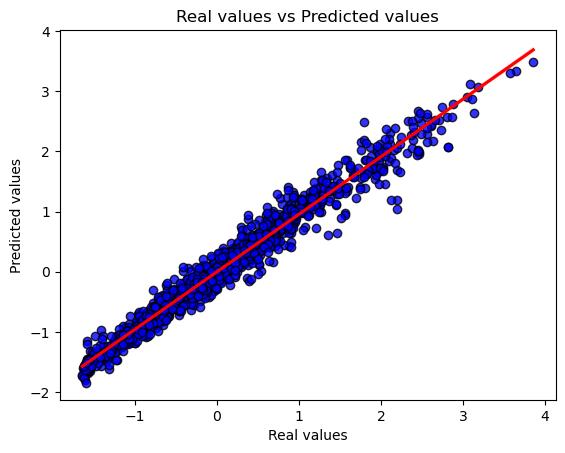

In [286]:
sns.regplot(x = y_test, y=pred_best_xgb, scatter_kws={'color': 'blue', 'edgecolor': 'k'}, line_kws={'color': 'red', 'linestyle': 'solid'})
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Real values vs Predicted values")
plt.show()

In [287]:
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print(f"Cross-Validation Score: {-cv_scores.mean()} (MSE)")

Cross-Validation Score: 0.038422601900779924 (MSE)


In [288]:
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {train_mse}")
print(f"Training R^2 Score: {train_r2}")
print(f"Testing Mean Squared Error: {test_mse}")
print(f"Testing R^2 Score: {test_r2}")

Training Mean Squared Error: 0.00541304270713287
Training R^2 Score: 0.9946327135511799
Testing Mean Squared Error: 0.02855082789504519
Testing R^2 Score: 0.9704386401224261


The cross-validation score, along with the comparison of training and test scores, does not reveal any signs of overfitting.

## Conclusion

After analyzing and merging the datasets, I built machine learning models to predict the number of transmissions. The XGBoost model achieved the best performance with the following results:

- **R² Score:** 0.97
- **Mean Squared Error (MSE):** 0.03
- **Mean Absolute Error (MAE):** 0.12

These results demonstrate that the model accurately predicts transmissions, explaining about 97% of the variance with minimal error. Additionally, cross-validation and performance metrics indicate no signs of overfitting. 

##### Suggestions for further improving the model:
- Feature Engineering
- Enhanced GPU Utilization
- Advanced Data preprocessing techniques

Overall, the **XGBoost model** provides a robust and reliable solution for forecasting future transmissions. 

## Thanks for reading!